In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")

/mnt/disk1/sumdev/CourseWork/a3_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets and Create Dataset Class

In [17]:
class EmotionDataset(Dataset):
    def __init__(self, json_file, model_name="all-MiniLM-L6-v2"):
        self.data = []
        self.model = SentenceTransformer(model_name)
        self.speaker_encoder = LabelEncoder()
        self.emotion_class_to_idx = {'neutral': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'fear': 4, 'disgust': 5, 'surprise': 6}
        with open(json_file, 'r') as f:
            data = json.load(f)
            for entry in data:
                self.data.append(entry)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        context_size = 5
        speakers = torch.tensor(self.speaker_encoder.fit_transform(entry["speakers"]), dtype=torch.long)[-(context_size):]
        emotions = torch.tensor([self.emotion_class_to_idx[emotion] for emotion in entry["emotions"]], dtype=torch.long)[-(context_size):]
        utterance_embeddings = torch.tensor(self.model.encode(entry["utterances"]), dtype=torch.float)[-(context_size):]
        utterance_embeddings = utterance_embeddings + utterance_embeddings[-1]
        triggers = [a if a != None else 0.0 for a in entry['triggers']]
        triggers = torch.tensor(triggers, dtype=torch.long)[-(context_size):]
        return torch.tensor(len(entry["speakers"])), speakers, emotions, utterance_embeddings, triggers


# Initialize the dataset and dataloader
model_name = 'all-MiniLM-L6-v2' # all-mpnet-base-v2
train_dataset = EmotionDataset("../Data/train_file.json", model_name=model_name)
val_dataset = EmotionDataset("../Data/val_file.json", model_name=model_name)
print('Length of train dataset:', len(train_dataset))
print('Length of val dataset:', len(val_dataset))

Length of train dataset: 6740
Length of val dataset: 843


In [18]:
length, speakers, emotions, utterance_embeddings, triggers = train_dataset[2]
print('Length:', length)
print('Speakers:', speakers)
print('Emotions:', emotions)
print('Utterance embeddings:', utterance_embeddings.shape)
print('Triggers:', triggers)

Length: tensor(7)
Speakers: tensor([2, 0, 2, 2, 2])
Emotions: tensor([0, 0, 0, 2, 4])
Utterance embeddings: torch.Size([5, 384])
Triggers: tensor([0, 0, 1, 1, 1])


### Training Dataset Class Distribution for Context Size = 5

In [19]:
trigger_cnt_0, trigger_cnt_1 = 0, 0
for i in range(len(train_dataset)):
    _, _, _, _, triggers = train_dataset[i]
    trigger_cnt_0 += (triggers == 0).sum().item()
    trigger_cnt_1 += (triggers == 1).sum().item()
    if i % 1000 == 0:
        print(i, end=' ')

print('\nCount of triggers 0:', trigger_cnt_0)
print('Count of triggers 1:', trigger_cnt_1)

0 1000 2000 3000 4000 5000 6000 
Count of triggers 0: 22797
Count of triggers 1: 8701


### Validation Dataset Class Distribution for Context Size = 5

In [20]:
trigger_cnt_0, trigger_cnt_1 = 0, 0
for i in range(len(val_dataset)):
    _, _, _, _, triggers = val_dataset[i]
    trigger_cnt_0 += (triggers == 0).sum().item()
    trigger_cnt_1 += (triggers == 1).sum().item()
    if i % 100 == 0:
        print(i, end=' ')

print('\nCount of triggers 0:', trigger_cnt_0)
print('Count of triggers 1:', trigger_cnt_1)

0 100 200 300 400 500 600 700 800 
Count of triggers 0: 2869
Count of triggers 1: 1038


## Create Dataloaders

In [21]:
import torch.nn as nn

def collate_fn(batch):
    length, speakers, emotions, utterance_embeddings, triggers = zip(*batch)
    length = torch.tensor(length, dtype=torch.long)
    speakers = nn.utils.rnn.pad_sequence(speakers, batch_first=True)
    emotions = nn.utils.rnn.pad_sequence(emotions, batch_first=True)
    triggers = nn.utils.rnn.pad_sequence(triggers, batch_first=True)
    utterance_embeddings = nn.utils.rnn.pad_sequence(utterance_embeddings, batch_first=True)        
    return length, speakers, emotions, utterance_embeddings, triggers


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print('Length of train_loader:', len(train_loader))
print('Length of val_loader:', len(val_loader))

Length of train_loader: 211
Length of val_loader: 27


In [22]:
for batch in train_loader:
    length, speakers, emotions, utterance_embeddings, triggers = batch
    print(length.shape, speakers.shape, emotions.shape, utterance_embeddings.shape, triggers.shape)
    # print("Length:", length)
    # print("Speakers:", speakers)
    # print("Emotions:", emotions)
    # print("Utterance embeddings:", utterance_embeddings)
    # print("Triggers:", triggers)
    break

torch.Size([32]) torch.Size([32, 5]) torch.Size([32, 5]) torch.Size([32, 5, 384]) torch.Size([32, 5])


## Create Emotion Flip Reasoning Model

In [5]:
import torch
import torch.nn as nn

class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_dim):
        super(CustomClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.input_layer = nn.Linear(input_size, input_size)
        self.tranformer_encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=input_size//8)
        self.transformer_encoder = nn.TransformerEncoder(self.tranformer_encoder_layer, num_layers=2)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.transformer_encoder(x) + x
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        x, _ = self.gru(x, h0)
        x = self.fc(x)
        x = self.softmax(x)
        return x

## Train the Model

In [24]:
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCH = 10
INPUT_SIZE = 384
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2

model = CustomClassifier(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(DEVICE)

cuda


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score


def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    model = model.to(device)
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    y_true = []
    y_pred = []
    
    for i, (_, speakers, emotions, utterance_embeddings, targets) in enumerate(dataloader, 1):
        utterance_embeddings = utterance_embeddings.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(utterance_embeddings)
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        _, preds = torch.max(outputs, 2)
        running_loss += loss.item() * utterance_embeddings.size(0)
        running_corrects += torch.sum(preds == targets).item()
        running_total += utterance_embeddings.size(0)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            target_expanded = targets.view(-1).cpu().numpy()
            preds_expanded = preds.view(-1).cpu().numpy()
            f1 = f1_score(target_expanded, preds_expanded, average='macro')
            accuracy = accuracy_score(target_expanded, preds_expanded)
            print(f"Batch {i}/{len(dataloader)} Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
        y_true.extend(targets.view(-1).cpu().numpy())
        y_pred.extend(preds.view(-1).cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return epoch_loss, epoch_acc, f1


def validate_model(model, dataloader, criterion, device):
    model.eval()
    model = model.to(device)
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for _, speakers, emotions, utterance_embeddings, targets in dataloader:
            utterance_embeddings = utterance_embeddings.to(device)
            targets = targets.to(device)
            outputs = model(utterance_embeddings)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            _, preds = torch.max(outputs, 2)
            running_loss += loss.item() * utterance_embeddings.size(0)
            running_corrects += torch.sum(preds == targets).item()
            running_total += utterance_embeddings.size(0)
            y_true.extend(targets.view(-1).cpu().numpy())
            y_pred.extend(preds.view(-1).cpu().numpy())
    val_loss = running_loss / len(dataloader.dataset)
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='macro')
    return val_loss, val_acc, val_f1


training_loss, validation_loss = [], []
training_acc, validation_acc = [], []
training_f1, validation_f1 = [], []

for epoch in range(NUM_EPOCH):
    print('-------------------------------------------------')
    print(f"Epoch {epoch+1}/{NUM_EPOCH}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    print(f"==> Train Loss: {train_loss:.4f} Accuracy: {train_acc:.4f} F1 Score: {train_f1:.4f}")
    training_loss.append(train_loss)
    training_acc.append(train_acc)
    training_f1.append(train_f1)
    val_loss, val_acc, val_f1 = validate_model(model, val_loader, criterion, DEVICE)
    print(f"==> Validation Loss: {val_loss:.4f} Accuracy: {val_acc:.4f} F1 Score: {val_f1:.4f}")
    validation_loss.append(val_loss)
    validation_acc.append(val_acc)
    validation_f1.append(val_f1)

-------------------------------------------------
Epoch 1/10
Batch 10/211 Loss: 0.6067, Accuracy: 0.7063, F1 Score: 0.4139
Batch 20/211 Loss: 0.5577, Accuracy: 0.7500, F1 Score: 0.4286
Batch 30/211 Loss: 0.5629, Accuracy: 0.7500, F1 Score: 0.4286
Batch 40/211 Loss: 0.6252, Accuracy: 0.6875, F1 Score: 0.4074
Batch 50/211 Loss: 0.6058, Accuracy: 0.7063, F1 Score: 0.4139
Batch 60/211 Loss: 0.5379, Accuracy: 0.7750, F1 Score: 0.4366
Batch 70/211 Loss: 0.5853, Accuracy: 0.7188, F1 Score: 0.4182
Batch 80/211 Loss: 0.5438, Accuracy: 0.7625, F1 Score: 0.4326
Batch 90/211 Loss: 0.5545, Accuracy: 0.7500, F1 Score: 0.4286
Batch 100/211 Loss: 0.5650, Accuracy: 0.7312, F1 Score: 0.4224
Batch 110/211 Loss: 0.5399, Accuracy: 0.7562, F1 Score: 0.4306
Batch 120/211 Loss: 0.5164, Accuracy: 0.7625, F1 Score: 0.5176
Batch 130/211 Loss: 0.5209, Accuracy: 0.7812, F1 Score: 0.6541
Batch 140/211 Loss: 0.5297, Accuracy: 0.7625, F1 Score: 0.6526
Batch 150/211 Loss: 0.5305, Accuracy: 0.7937, F1 Score: 0.7316
Bat

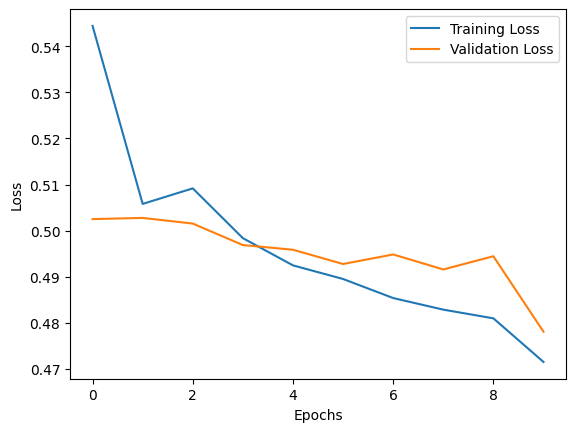

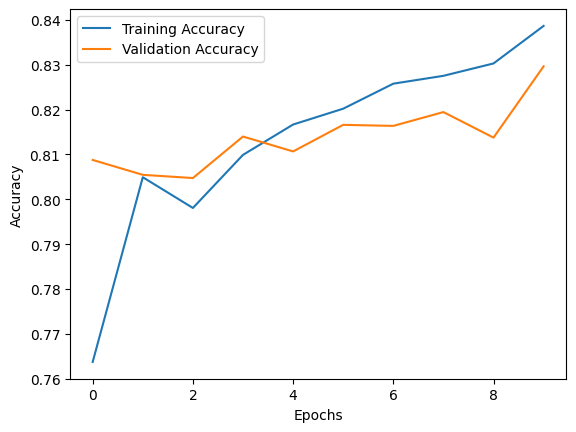

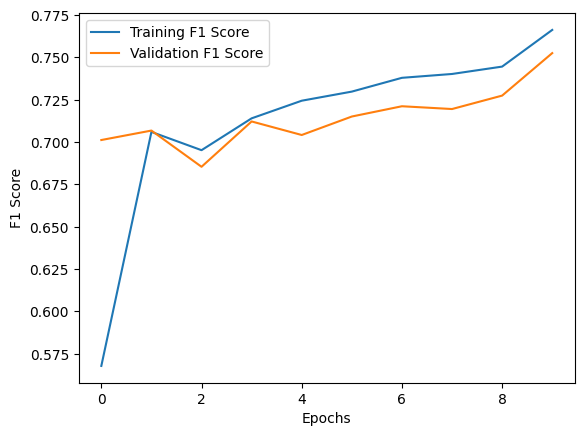

In [30]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(training_acc, label='Training Accuracy')
plt.plot(validation_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(training_f1, label='Training F1 Score')
plt.plot(validation_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [29]:
model = model.to('cpu')
torch.save(model.state_dict(), "M3.pt")

## Run Inference on Validation Dataset


In [28]:
for _, speakers, emotions, utterance_embeddings, targets in val_loader:
    speakers = speakers.to(DEVICE)
    emotions = emotions.to(DEVICE)
    utterance_embeddings = utterance_embeddings.to(DEVICE)
    targets = targets.to(DEVICE)
    optimizer.zero_grad()
    model = model.to(DEVICE)
    outputs = model(utterance_embeddings)
    loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
    _, preds = torch.max(outputs, 2)
    target_expanded = targets.view(-1).cpu().numpy()
    preds_expanded = preds.view(-1).cpu().numpy()
    print(len(target_expanded), len(preds_expanded))
    f1 = f1_score(target_expanded, preds_expanded, average='macro')
    accuracy = accuracy_score(target_expanded, preds_expanded)
    print(f"Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print(target_expanded)
    print(preds_expanded)
    break

160 160
Loss: 0.4849, Accuracy: 0.8187, F1 Score: 0.7375
[0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1
 1 1 0 0 0 0 0 0 0 0 1 0]
[0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0]


## Predict Emotions and Detecting the Flips in Emotions in a conversation

In [2]:
with open("../Data/train_file.json", 'r') as f:
    train_json = json.load(f)
with open("../Data/val_file.json", 'r') as f:
    val_json = json.load(f)
print('Train Samples:', len(train_json))
print('Val Samples:', len(val_json))

Train Samples: 6740
Val Samples: 843


In [3]:
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score, accuracy_score

sentence_emb_model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCH = 10
INPUT_SIZE = 384
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2

trained_model = CustomClassifier(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(DEVICE)
trained_model.load_state_dict(torch.load("M3.pt"))

<All keys matched successfully>

In [14]:
def emotion_flip_inference(model:CustomClassifier, conversation:dict):
    model.eval()
    utterances = conversation["utterances"]
    true_emotions = conversation["emotions"]
    speakers = conversation["speakers"]
    triggers = conversation["triggers"]
    context_size = 5
    
    # Obtain the utterance embeddings and predict the emotion flip reason of last utterance for context size 5
    utterance_embeddings = torch.tensor(sentence_emb_model.encode(utterances), dtype=torch.float)[-(context_size):]
    utterance_embeddings = utterance_embeddings + utterance_embeddings[-1]
    triggers_true_label = [a if a != None else 0.0 for a in triggers]
    triggers_true_label = torch.tensor(triggers_true_label, dtype=torch.long)[-(context_size):]
    
    # Obtain the predicted triggers
    utterance_embeddings = utterance_embeddings.unsqueeze(0).to(DEVICE)
    triggers_predictions = model(utterance_embeddings)
    _, triggers_predictions = torch.max(triggers_predictions, 2)
    triggers_predictions = triggers_predictions.view(-1).cpu()

    print('Speakers:', speakers[-context_size:])
    print('Utterances:', utterances[-context_size:])
    print('Emotions:', true_emotions[-context_size:])
    print()
    print('True triggers:', triggers_true_label)
    print('Predicted triggers:', triggers_predictions)

    # Show the Accuracy and F1 Score of the prediction
    accuracy = accuracy_score(triggers_true_label.cpu().numpy(), triggers_predictions.numpy())
    f1 = f1_score(triggers_true_label.cpu().numpy(), triggers_predictions.numpy(), average='macro')
    print('Accuracy of Prediction:', accuracy)
    print('F1 Score of Prediction:', f1)
    

ind = 4
conversation = val_json[ind]
emotion_flip_inference(trained_model, conversation)    

Speakers: ['Joey', 'Rachel', 'Rachel', 'Rachel', 'Rachel']
Utterances: ["Well you're whippin' so slow! Can't you do it any faster?", 'Joey!', 'Come on!', "I don't wanna make any mistakes, alright?", "This is the only dessert and if I screw it up everybody's gonna be like \x93Oh, remember that Thanksgiving when Rachel screwed up the trifle?\x94"]
Emotions: ['anger', 'anger', 'anger', 'anger', 'fear']

True triggers: tensor([0, 0, 0, 1, 1])
Predicted triggers: tensor([0, 0, 0, 1, 1])
Accuracy of Prediction: 1.0
F1 Score of Prediction: 1.0
